# Convolutional Neural Network - Gap / Char Classification
Using TensorFlow

Also need to convert images in folder into csv data file

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

%matplotlib notebook

# Creating CSV
import glob
import csv

print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("TensorFlow: " + tf.__version__)

OpenCV: 3.1.0-dev
Numpy: 1.12.0
TensorFlow: 1.0.0-rc1


In [2]:
def implt(img, cmp=None, t=''):
    """ Show image using plt """
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()

    
def sofmaxLabels(lab, clas):
    """ Transform data for sofmax classification """
    newLab = np.zeros((len(lab), clas), dtype=np.int8)
    for i in range(len(lab)):
        newLab[i][int(lab[i][0])] = 1
    return newLab

## Load Images and Lables in CSV

In [3]:
LANG = 'cz'
EN_CLAS = 53
CZ_CLAS = 83
CLAS = 53

if LANG == 'en':
    CLAS = EN_CLAS
elif LANG == 'cz':
    CLAS = CZ_CLAS

# dimension 64x64
images = np.genfromtxt('data/charclas/' + LANG + '-data.csv', delimiter=',')
labels = np.genfromtxt('data/charclas/' + LANG + '-labels.csv', delimiter=',')
labels = np.reshape(labels, (len(labels), 1))

# Regularization of images
images[images < 40] = 0
images = images.astype(np.float32)
images = np.multiply(images, 1.0 / 255.0)

print("CSV data files loaded.")
print("Number of images: " + str(len(images)))

div = int(0.80 * len(images))

llabels = sofmaxLabels(labels, CLAS)

trainData = images[0:div]
evalData = images[div:]
trainLabels = llabels[0:div]
evalLabels = llabels[div:]

print("Training images: %g" % div)

CSV data files loaded.
Number of images: 2572
Training images: 2057


# Create classifier

In [4]:
class TrainingPlot:
    """ Creating live plot during training """
    trainLoss = []
    trainAcc = []
    validAcc = []
    testInterval = 0
    lossInterval = 0
    interval = 0
    ax1 = None
    ax2 = None
    fig = None
    
    def __init__(self, steps, testItr, lossItr):
        self.testInterval = testItr
        self.lossInterval = lossItr
        self.interval = steps
              
        self.fig, self.ax1 = plt.subplots()
        self.ax2 = self.ax1.twinx()
        self.ax1.set_autoscaley_on(True)
        plt.ion()
        
        self.updatePlot()
        
        self.ax1.set_xlabel('iteration')
        self.ax1.set_ylabel('train loss')
        self.ax2.set_ylabel('test accuracy')

        
    def updatePlot(self):        
        self.fig.canvas.draw()

        
    def updateLoss(self, lossTrain, index):
        # Threshold the first loss addition - better graph scale
        if len(self.trainLoss) == 0 and lossTrain > 2:
            lossTrain = 2
            
        self.trainLoss.append(lossTrain)        
        self.ax1.plot(self.lossInterval * np.arange(len(self.trainLoss)), self.trainLoss, 'b')
        
        self.updatePlot()
        
    def updateAcc(self, accVal, accTrain, index):
        self.validAcc.append(accVal)
        self.trainAcc.append(accTrain)
                
        self.ax2.plot(self.testInterval * np.arange(len(self.validAcc)), self.validAcc, 'r')
        self.ax2.plot(self.testInterval * np.arange(len(self.trainAcc)), self.trainAcc, 'g')
        
        self.ax2.set_title('Valid. Accuracy: {:.4f}'.format(self.validAcc[-1]))
        
        self.updatePlot()

### Dataset

In [5]:
class DataSet:
    """ Class for training data"""
    images = None
    labels = None
    length = 0
    index = 0

    def __init__(self, img, lbl):
        """ Crate the dataset """
        self.images = img
        self.labels = lbl
        self.length = len(img)
        self.index = 0

    def next_batch(self, batchSize):
        """Return the next batch from the data set."""
        start = self.index
        self.index += batchSize
        
        if self.index > self.length:
            # Shuffle the data
            perm = np.arange(self.length)
            np.random.shuffle(perm)
            self.images = self.images[perm]
            self.labels = self.labels[perm]
            # Start next epoch
            start = 0
            self.index = batchSize
        

        end = self.index
        return self.images[start:end], self.labels[start:end]

In [6]:
trainSet = DataSet(trainData, trainLabels)

### KNN

In [7]:
# tf Graph Input
xtr = tf.placeholder("float", [None, 4096])
xte = tf.placeholder("float", [4096])

# Nearest Neighbor calculation using L1 Distance
# Calculate L1 Distance
distance = tf.reduce_sum(tf.abs(tf.add(xtr, tf.negative(xte))), reduction_indices=1)
# Prediction: Get min distance index (Nearest neighbor)
pred = tf.arg_min(distance, 0)

accuracy = 0.

# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    # loop over test data
    for i in range(len(evalData)):
        # Get nearest neighbor
        nn_index = sess.run(pred, feed_dict={xtr: trainData, xte: evalData[i, :]})
        # Get nearest neighbor class label and compare it to its true label
#         print("Test", i, "Prediction:", np.argmax(trainLabels[nn_index]), \
#             "True Class:", np.argmax(evalLabels[i]))
        # Calculate accuracy
        if np.argmax(trainLabels[nn_index]) == np.argmax(evalLabels[i]):
            accuracy += 1./len(evalData)
    print("Done!")
print("Accuracy:", accuracy)

Done!
Accuracy: 0.6601941747572772


## Convulation Neural Network

### Graph

In [8]:
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, [None, 4096], name="x")
y_ = tf.placeholder(tf.float32, [None, CLAS])

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def conv2dVLD(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


x_image = tf.reshape(x, [-1, 64, 64, 1])

# 1. Layer - Convulation + Subsampling
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 6], stddev=0.1), name="W_conv1")
b_conv1 = tf.Variable(tf.constant(0.1, shape=[6]), name="b_conv1")

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

# 2. Layer - Max Pool
h_pool1 = max_pool_2x2(h_conv1)

# 3. Layer - Convulation + Subsampling
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 6, 12], stddev=0.1), name="W_conv2")
b_conv2 = tf.Variable(tf.constant(0.1, shape=[12]), name="b_conv2")

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

# 4. Layer - Max Pool
h_pool2 = max_pool_2x2(h_conv2)

# 5. Layer - Convulation + Subsampling
W_conv3 = tf.Variable(tf.truncated_normal([3, 3, 12, 18], stddev=0.1), name="W_conv3")
b_conv3 = tf.Variable(tf.constant(0.1, shape=[18]), name="b_conv3")

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)

# 6. Layer - Max Pool
h_pool3 = max_pool_2x2(h_conv3)

# Connected layer
W_fc1 = tf.Variable(tf.truncated_normal([8*8*18, 120], stddev=0.1), name="W_fc1")
b_fc1 = tf.Variable(tf.constant(0.1, shape=[120]), name="b_fc1")

h_conv2_flat = tf.reshape(h_pool3, [-1, 8*8*18])
h_fc1 = tf.nn.relu(tf.matmul(h_conv2_flat, W_fc1) + b_fc1)

# Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Output layer
W_fc2 = tf.Variable(tf.truncated_normal([120, CLAS], stddev=0.1), name="W_fc2")
b_fc2 = tf.Variable(tf.constant(0.1, shape=[CLAS]), name="b_fc2")

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

# Creating activation function for real use
activation = tf.argmax(tf.matmul(h_fc1, W_fc2) + b_fc2, 1)
tf.add_to_collection("activation", activation)

# Loss function
# cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv + 1e-10))
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))

# Regularization with L2 Regularization with decaying learning rate 
beta = 0.1
regularizers = tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(W_fc1)
loss = tf.reduce_mean(cross_entropy + beta * regularizers)

# Optimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
# train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

# Evaluating
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Training

<IPython.core.display.Javascript object>


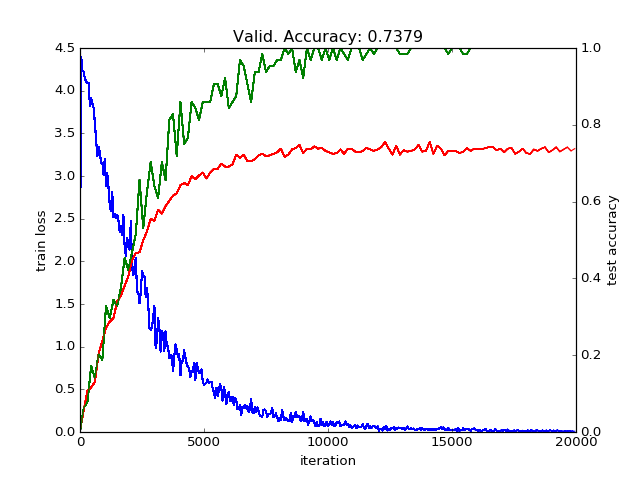

Eval accuracy 0.745631


In [9]:
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

### SETTINGS  ###
TRAIN_STEPS = 20000
TEST_ITER = 150
COST_ITER = 50
BATCH_SIZE = 64

# Graph for live ploting
trainPlot = TrainingPlot(TRAIN_STEPS, TEST_ITER, COST_ITER)

for i in range(TRAIN_STEPS):
    trainBatch, labelBatch = trainSet.next_batch(BATCH_SIZE)

    
    if i%COST_ITER == 0:    
        cost = cross_entropy.eval(feed_dict={x: trainBatch, y_: labelBatch, keep_prob: 1.0})
        trainPlot.updateLoss(cost, i // COST_ITER)
    
    if i%TEST_ITER == 0:
        accEval = accuracy.eval(feed_dict={x: evalData, y_: evalLabels, keep_prob: 1.0})
        accTrain = accuracy.eval(feed_dict={x: trainBatch, y_: labelBatch, keep_prob: 1.0})
        trainPlot.updateAcc(accEval, accTrain, i // TEST_ITER)
        
    if i%2000 == 0:
        saver.save(sess, 'models/CharClassifier-' + LANG)
        saver.export_meta_graph('models/CharClassifier-' + LANG + '.meta')

    train_step.run(feed_dict={x: trainBatch, y_: labelBatch, keep_prob: 0.4})

saver.save(sess, 'models/CharClassifier-' + LANG)
saver.export_meta_graph('models/CharClassifier-' + LANG + '.meta')    

print("Eval accuracy %g" % accuracy.eval(feed_dict={x: evalData, y_: evalLabels, keep_prob: 1.0}))
# print("Total accuracy: %g" % accuracy.eval(feed_dict={x: images, y_: llabels, keep_prob: 1.0}))

sess.close()

### NOTES ###
#
# Need accuracy higher than 57 %
# In case of overfitting - try lower peek_prob or higher regul param
#
#
# Increasing regularization (beta) from 0.001 to 0.1:
# validation accuracy increased from 0.6126 to 0.6464 (5000 iter, could grow more)